In [1]:
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
from tensorflow.keras import layers
import tensorflow_hub as hub
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load Dataset
path = '../Code/benchmark_liver_tumor/raw/np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr.npy'), np.load(path+'X_m_tr.npy', allow_pickle=True), np.load(path+'X_i_tr.npy'), np.load(path+'Y_tr.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te.npy'), np.load(path+'X_m_te.npy', allow_pickle=True), np.load(path+'X_i_te.npy'), np.load(path+'Y_te.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(10843,) (10843, 6) (10843, 3, 96, 96) (10843,) (10843, 3)
(2764,) (2764, 6) (2764, 3, 96, 96) (2764,) (2764, 3)


In [3]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)

(10843, 96, 96, 3)
(2764, 96, 96, 3)


Model: "functional_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_564 (Conv2D)             (None, 47, 47, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_564 (BatchN (None, 47, 47, 32)   96          conv2d_564[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, 47, 47, 32)   0           batch_normalization_564[0][0]    
_______________________________________________________________________________________

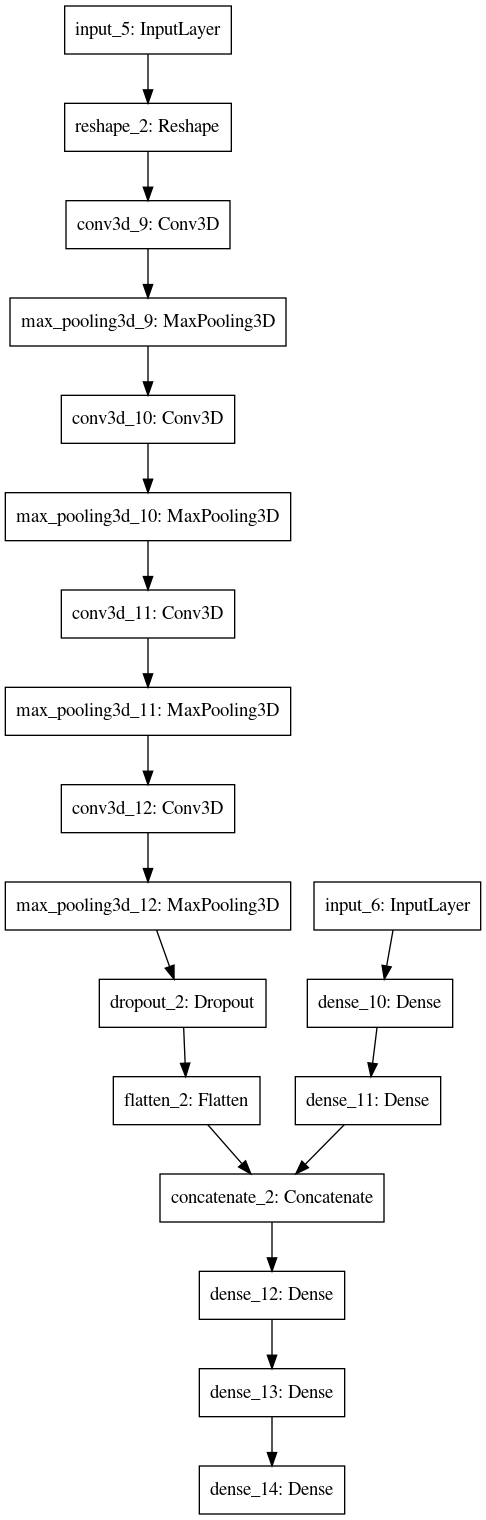

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file= './inceptionV3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (96, 96, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)  
inc_v3_output = layers.Flatten()(x)

# Build Model (Meta-data)
dnn_input = tf.keras.Input((X_m_tr.shape[1],))
h = tf.keras.layers.Dense(6, activation='tanh')(dnn_input)
dnn_output = tf.keras.layers.Dense(6, activation='tanh')(h)

# Fusion Model
concat = tf.keras.layers.Concatenate(axis=-1)([inc_v3_output, dnn_output])
h = tf.keras.layers.Dense(128, activation='tanh')(concat)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_dnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn_meta = tf.keras.Model(inputs=[pre_trained_model.input, dnn_input], outputs=cnn_dnn_output)
cnn_meta.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_meta.summary()

display(Image(filename="./model/cnn_meta.png"))

In [15]:
# Train Model
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_meta_history = cnn_meta.fit([X_i_tr, X_m_tr], Y_tr_cat, validation_data=([X_i_te, X_m_te], Y_te_cat), epochs=20, batch_size=512, shuffle=True, verbose=2, callbacks=[es])


Epoch 1/20
22/22 - 25s - loss: 1.0528 - accuracy: 0.6521 - val_loss: 0.9452 - val_accuracy: 0.6075
Epoch 2/20
22/22 - 23s - loss: 0.8547 - accuracy: 0.6699 - val_loss: 0.9213 - val_accuracy: 0.6075
Epoch 3/20
22/22 - 25s - loss: 0.8459 - accuracy: 0.6699 - val_loss: 0.9345 - val_accuracy: 0.6075
Epoch 4/20
22/22 - 25s - loss: 0.8277 - accuracy: 0.6699 - val_loss: 0.8971 - val_accuracy: 0.6035
Epoch 5/20
22/22 - 24s - loss: 0.8020 - accuracy: 0.6713 - val_loss: 0.9103 - val_accuracy: 0.6078
Epoch 6/20
22/22 - 25s - loss: 0.7553 - accuracy: 0.6921 - val_loss: 0.9232 - val_accuracy: 0.6284
Epoch 7/20
22/22 - 23s - loss: 0.6949 - accuracy: 0.7140 - val_loss: 0.9548 - val_accuracy: 0.6245
Epoch 8/20
22/22 - 25s - loss: 0.6325 - accuracy: 0.7455 - val_loss: 1.0373 - val_accuracy: 0.6299
Epoch 9/20
22/22 - 24s - loss: 0.5644 - accuracy: 0.7747 - val_loss: 1.2185 - val_accuracy: 0.6277
Epoch 10/20
22/22 - 24s - loss: 0.4852 - accuracy: 0.8145 - val_loss: 1.0958 - val_accuracy: 0.6357
Epoch 11/